(**Click the icon below to open this notebook in Colab**)

[![Open InColab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/xiangshiyin/machine-learning-for-actuarial-science/blob/main/2025-spring/week09/notebook/demo.ipynb)

# Work with Imbalanced Data

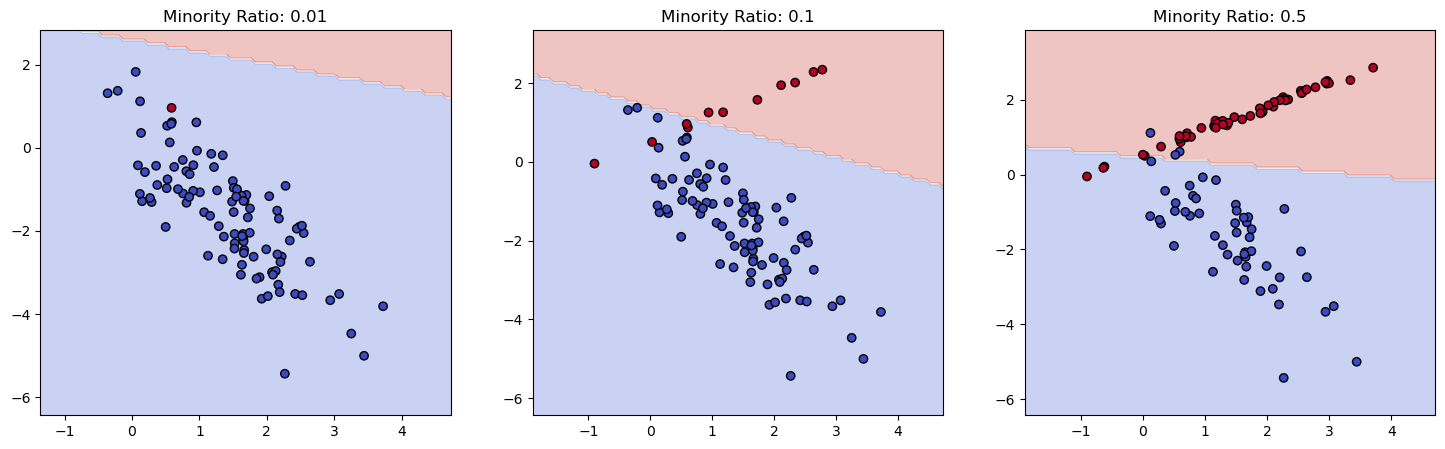

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Function to plot decision boundaries
def plot_decision_boundaries(model, X, y, ax, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    ax.set_title(title)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())

inputs_to_visualize = []

for minority_ratio in [0.01, 0.1, 0.5]:
    # Generate an imbalanced dataset
    X, y = make_classification(n_samples=500, n_features=2, n_redundant=0, n_clusters_per_class=1,
                               weights=[1 - minority_ratio, minority_ratio], class_sep=1.5, random_state=42)
    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Fit a logistic regression model
    model = LogisticRegression(solver='liblinear')
    model.fit(X_train, y_train)
    # Store the input data for visualization
    inputs_to_visualize.append((minority_ratio, model, X_test, y_test))

# visualize all in a 1x3 grid
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, (minority_ratio, model, X_test, y_test) in enumerate(inputs_to_visualize):
    plot_decision_boundaries(model, X_test, y_test, axes[i], f"Minority Ratio: {minority_ratio}")
plt.show()


# Model Evaluation on Imbalanced Dataset

## ROC-AUC

In [ ]:
# example of a roc curve for a predictive model
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
# generate 2 class dataset
X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# fit a model
lr = LogisticRegression(solver='lbfgs')
lr.fit(trainX, trainy)
# predict probabilities
yhat = lr.predict_proba(testX)
# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]
# plot no skill roc curve
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
# calculate roc curve for the model
fpr, tpr, thresholds = roc_curve(testy, pos_probs)
roc_auc_lr = roc_auc_score(testy, pos_probs)
# plot lr roc curve
plt.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.title(f'ROC curve for Logistic Regression Model. AUC = {roc_auc_lr:.2f}')
plt.show()

In [ ]:
from sklearn.dummy import DummyClassifier

dc = DummyClassifier(strategy='stratified')
dc.fit(trainX, trainy)
yhat_dummy = dc.predict_proba(testX)
pos_probs_dummy = yhat_dummy[:, 1]
# calculate roc auc
roc_auc_dummy = roc_auc_score(testy, pos_probs_dummy)
print(f'ROC AUC = {roc_auc_dummy:.2f}')

In [ ]:
pos_probs_dummy = yhat_dummy[:, 1]

plt.hist(pos_probs_dummy, bins=10, label='Positive Class Distribution', density=True)
plt.legend()
plt.show()

In [ ]:
pos_probs = yhat[:, 1]
neg_probs = yhat[:, 0]

plt.hist(pos_probs, bins=100, label='Positive Class Distribution', density=True)
plt.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Threshold = 0.5')
plt.legend()
plt.show()

In [ ]:
np.sum(pos_probs>=0.5), np.sum(pos_probs<0.5)

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html


|               | Negative Prediction | Positive Prediction |
|--------------|--------------------|--------------------|
| **Negative Class** | True Negative (TN)  | False Positive (FP) |
| **Positive Class** | False Negative (FN) | True Positive (TP) |

In [ ]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(testy, lr.predict(testX))
print(matrix)

## PR-AUC

In [ ]:
from sklearn.metrics import precision_recall_curve

# predict probabilities
yhat = lr.predict_proba(testX)
# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]
# calculate the no skill line as the proportion of the positive class
no_skill = len(y[y==1]) / len(y)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
# calculate model precision-recall curve
precision, recall, _ = precision_recall_curve(testy, pos_probs)
# plot the model precision-recall curve
plt.plot(recall, precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
from sklearn.metrics import auc

auc_score = auc(recall, precision)
print('PR AUC: %.3f' % auc_score)

In [ ]:


precision_dummy, recall_dummy, _ = precision_recall_curve(testy, pos_probs_dummy)
auc_score = auc(recall_dummy, precision_dummy)
print('PR AUC: %.3f' % auc_score)

## Severly Imbalanced Data

### ROC-AUC

In [ ]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
 
# plot no skill and model roc curves
def plot_roc_curve(test_y, naive_probs, model_probs):
	# plot naive skill roc curve
	fpr, tpr, _ = roc_curve(test_y, naive_probs)
	plt.plot(fpr, tpr, linestyle='--', label='No Skill')
	# plot model roc curve
	fpr, tpr, _ = roc_curve(test_y, model_probs)
	plt.plot(fpr, tpr, marker='.', label='Logistic')
	# axis labels
	plt.xlabel('False Positive Rate')
	plt.ylabel('True Positive Rate')
	# show the legend
	plt.legend()
	# show the plot
	plt.show()
 
# generate 2 class dataset
X, y = make_classification(n_samples=1000, n_classes=2, weights=[0.99, 0.01], random_state=1)
# split into train/test sets with same class ratio
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2, stratify=y)
# no skill model, stratified random class predictions
dc = DummyClassifier(strategy='stratified')
dc.fit(trainX, trainy)
yhat_dc = dc.predict_proba(testX)
naive_probs = yhat_dc[:, 1]
# calculate roc auc
roc_auc_dc = roc_auc_score(testy, naive_probs)
print('No Skill ROC AUC %.3f' % roc_auc_dc)
# skilled model
lr = LogisticRegression(solver='lbfgs')
lr.fit(trainX, trainy)
yhat = lr.predict_proba(testX)
lr_probs = yhat[:, 1]
# calculate roc auc
roc_auc = roc_auc_score(testy, lr_probs)
print('Logistic ROC AUC %.3f' % roc_auc)
# plot roc curves
plot_roc_curve(testy, naive_probs, lr_probs)

### PR-AUC

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
 
# plot no skill and model precision-recall curves
def plot_pr_curve(test_y, model_probs):
	# calculate the no skill line as the proportion of the positive class
	no_skill = len(test_y[test_y==1]) / len(test_y)
	# plot the no skill precision-recall curve
	plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
	# plot model precision-recall curve
	precision, recall, _ = precision_recall_curve(testy, model_probs)
	plt.plot(recall, precision, marker='.', label='Logistic')
	# axis labels
	plt.xlabel('Recall')
	plt.ylabel('Precision')
	# show the legend
	plt.legend()
	# show the plot
	plt.show()
 
naive_probs = yhat_dc[:, 1]
# calculate the precision-recall auc
precision_dc, recall_dc, _ = precision_recall_curve(testy, naive_probs)
auc_score_dc = auc(recall_dc, precision_dc)
print('No Skill PR AUC: %.3f' % auc_score_dc)

model_probs = yhat[:, 1]
# calculate the precision-recall auc
precision_lr, recall_lr, _ = precision_recall_curve(testy, model_probs)
auc_score_lr = auc(recall_lr, precision_lr)
print('Logistic PR AUC: %.3f' % auc_score_lr)
# plot precision-recall curves
plot_pr_curve(testy, model_probs)

To explain why the ROC and PR curves tell a different story, recall that the PR curve focuses on the minority class, whereas the ROC curve covers both classes.

In [ ]:
pos_probs = yhat[:, 1]
plt.hist(pos_probs, bins=100)
plt.show()